<a href="https://colab.research.google.com/github/AylinNaebzadeh/MultiLabel-Text-Classification/blob/main/Mental_Health_Topic_Classification_S3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Main Source:

https://medium.com/analytics-vidhya/an-introduction-to-multi-label-text-classification-b1bcb7c7364c

In [2]:
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.1 MB/s eta 0:00:00


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import accuracy_score

In [5]:
train_data = pd.read_csv("primate_data.csv")

In [6]:
train_data.head()

,post_title,post_text,Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down,Feeling-down-depressed-or-hopeless,Feeling-tired-or-having-little-energy,Little-interest-or-pleasure-in-doing,Moving-or-speaking-so-slowly-that-other-people-could-have-noticed-Or-the-opposite-being-so-fidgety-or-restless-that-you-have-been-moving-around-a-lot-more-than-usual,Poor-appetite-or-overeating,Thoughts-that-you-would-be-better-off-dead-or-of-hurting-yourself-in-some-way,Trouble-concentrating-on-things-such-as-reading-the-newspaper-or-watching-television,Trouble-falling-or-staying-asleep-or-sleeping-too-much
0,I don't feel original anymore.,"When I was in high school a few years back, I ...",1,0.0,1,1,0,0.0,0.0,0.0,0
1,I don’t have anyone to talk to and I don’t kno...,Nine years ago I was diagnosed with depression...,1,1.0,0,0,1,0.0,0.0,0.0,0
2,Stuck between moving forward and killing myself,Some background information: My GF of almost 3...,1,1.0,1,1,0,0.0,1.0,0.0,0
3,I need help on how to help my girlfriend.,"My girlfriend ,of about 3 months now ,has been...",1,1.0,0,0,0,0.0,1.0,0.0,0
4,I've been feeling this way for some tine,I'm alway feeling like this. It doesn't even m...,1,1.0,0,0,0,0.0,0.0,0.0,0


In [7]:
train_data.shape

(2003, 11)

In [8]:
x = train_data.iloc[:, 2:]
rowsums = train_data.iloc[:, 1:].sum(axis=1)
no_label_count = 0
for sum in rowsums.items():
  if sum == 0:
    no_label_count += 1

print("Total number of posts = ",len(train_data))
print("Total number of posts without label = ",no_label_count)
print("Total labels = ", x.sum())

Total number of posts =  2003
Total number of posts without label =  0
Total labels =  Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down                                                                            1680.0
Feeling-down-depressed-or-hopeless                                                                                                                                       1664.0
Feeling-tired-or-having-little-energy                                                                                                                                     688.0
Little-interest-or-pleasure-in-doing                                                                                                                                      949.0
Moving-or-speaking-so-slowly-that-other-people-could-have-noticed-Or-the-opposite-being-so-fidgety-or-restless-that-you-have-been-moving-around-a-lot-more-than-usual     527.0
Poor-appetite-or-overeating      

<ipython-input-8-5437e7b6b4b5>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rowsums = train_data.iloc[:, 1:].sum(axis=1)


In [9]:
print("Check for missing values in Train dataset")
print(train_data.isnull().sum().sum())

Check for missing values in Train dataset
6


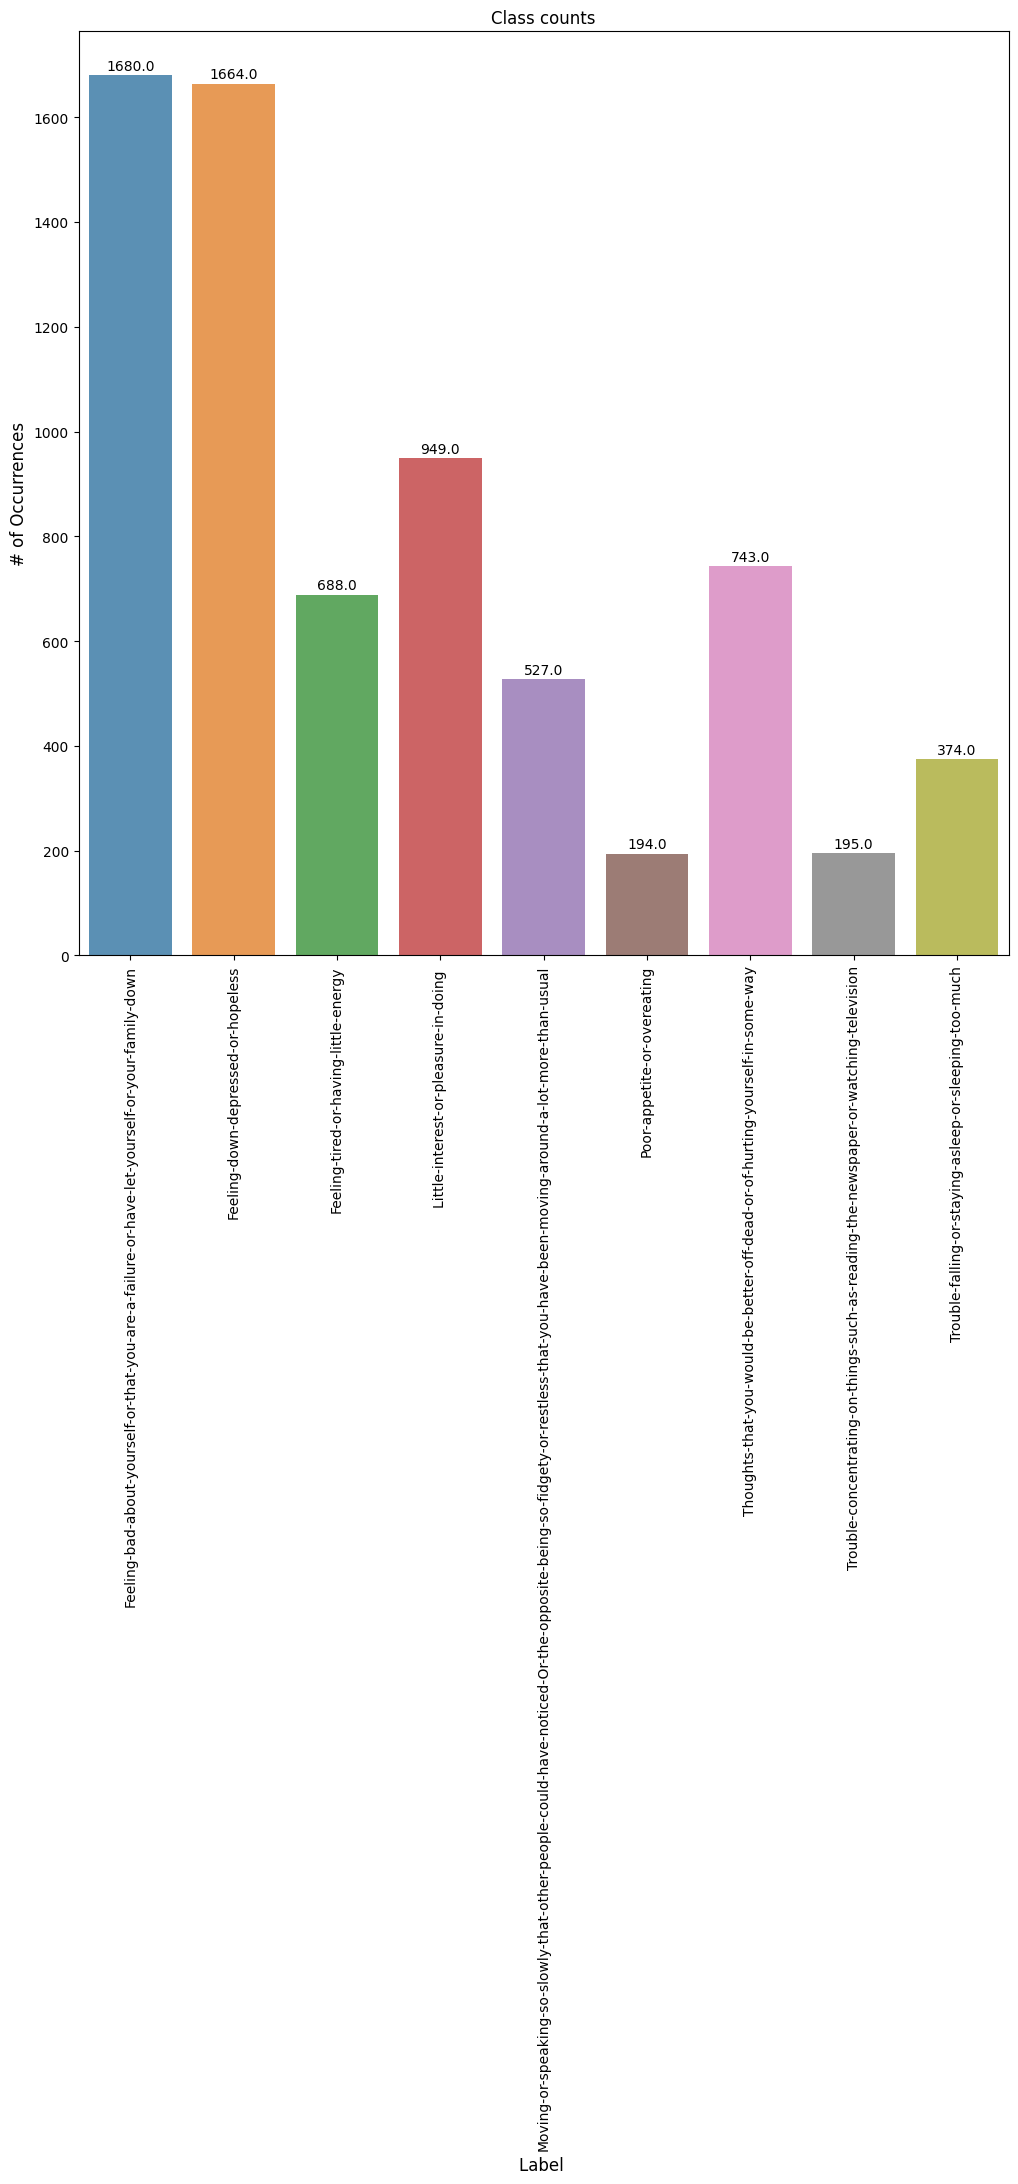

In [14]:
x=train_data.iloc[:, 2:].sum()
#plot
plt.figure(figsize=(12, 12))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Class counts")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Label ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

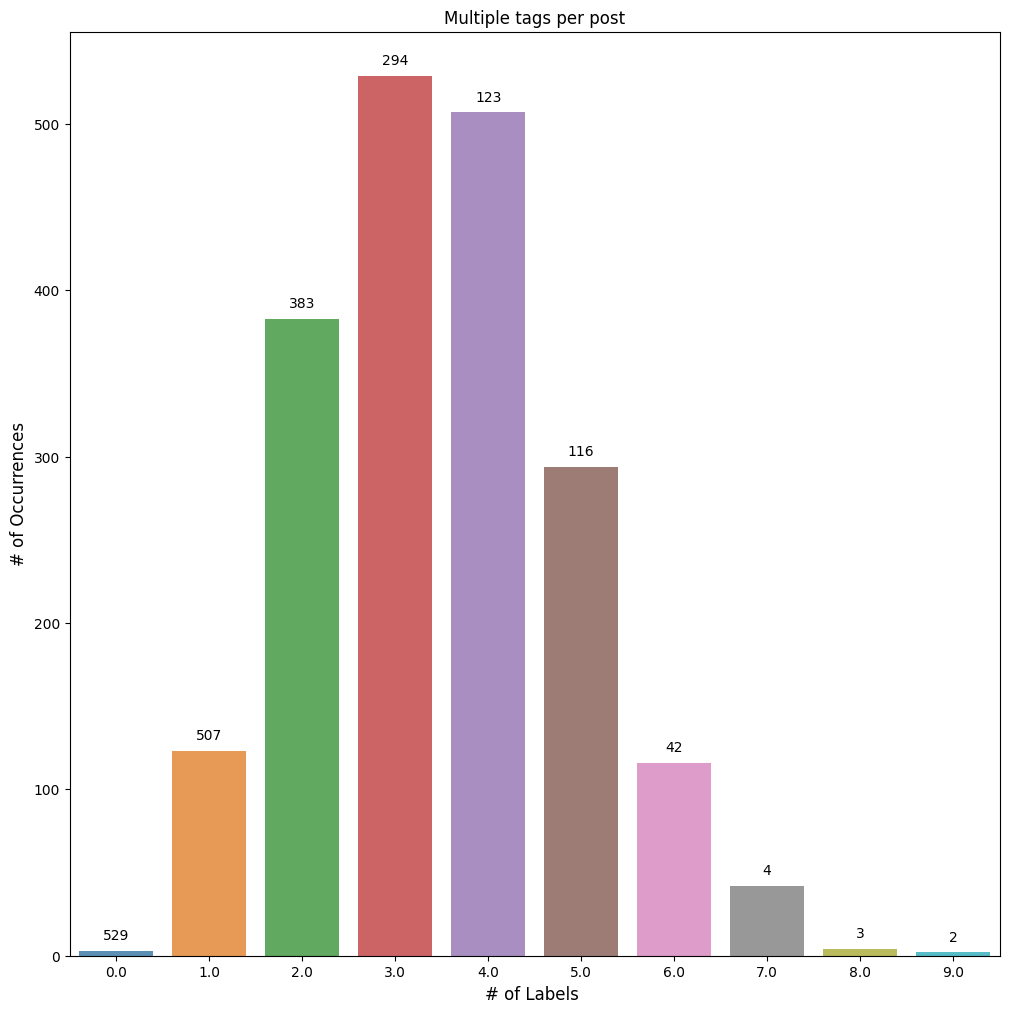

In [15]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(12,12))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Multiple tags per post")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of Labels ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [16]:
train_data['Text'] = train_data['post_title']+ ' ' +train_data['post_text']

In [ ]:
train_data.drop(columns=['post_title'], inplace=True)

In [22]:
train_data.drop(columns=['post_text'], inplace=True)

In [23]:
train_data.head()

,Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down,Feeling-down-depressed-or-hopeless,Feeling-tired-or-having-little-energy,Little-interest-or-pleasure-in-doing,Moving-or-speaking-so-slowly-that-other-people-could-have-noticed-Or-the-opposite-being-so-fidgety-or-restless-that-you-have-been-moving-around-a-lot-more-than-usual,Poor-appetite-or-overeating,Thoughts-that-you-would-be-better-off-dead-or-of-hurting-yourself-in-some-way,Trouble-concentrating-on-things-such-as-reading-the-newspaper-or-watching-television,Trouble-falling-or-staying-asleep-or-sleeping-too-much,Text
0,1,0.0,1,1,0,0.0,0.0,0.0,0,I don't feel original anymore. When I was in h...
1,1,1.0,0,0,1,0.0,0.0,0.0,0,I don’t have anyone to talk to and I don’t kno...
2,1,1.0,1,1,0,0.0,1.0,0.0,0,Stuck between moving forward and killing mysel...
3,1,1.0,0,0,0,0.0,1.0,0.0,0,I need help on how to help my girlfriend. My g...
4,1,1.0,0,0,0,0.0,0.0,0.0,0,I've been feeling this way for some tine I'm a...


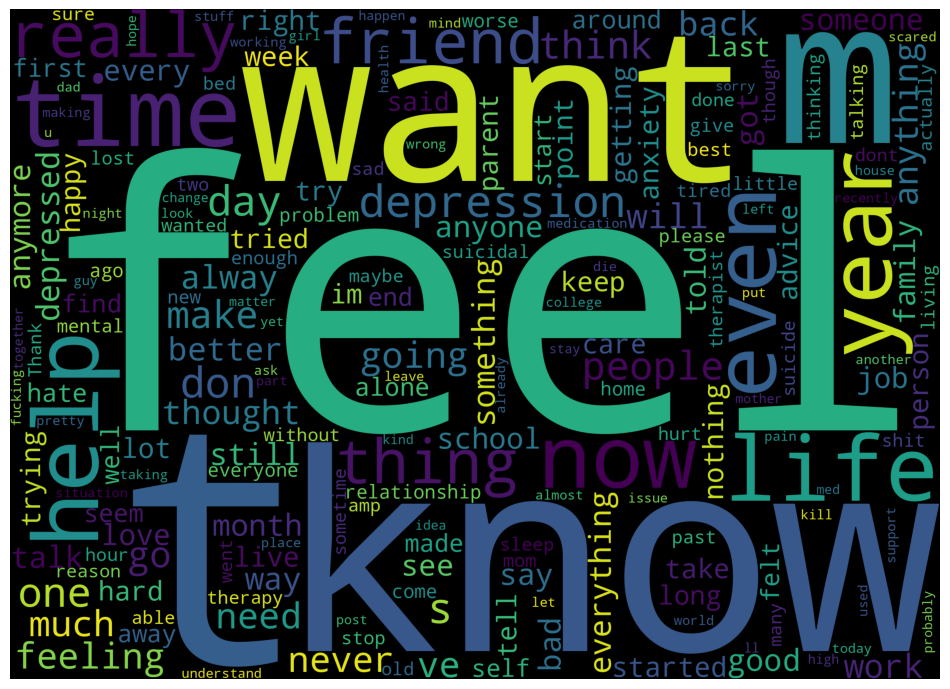

In [24]:
plt.figure(figsize=(12,12))
#text = description_category.description.values
cloud = WordCloud(stopwords=STOPWORDS, background_color='black', collocations=False, width=2500, height=1800).generate(" ".join(train_data['Text']))
plt.axis('off')
plt.imshow(cloud)

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
#Remove Stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

train_data['Text'] = train_data['Text'].apply(lambda x: remove_stopwords(x))

In [28]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

train_data['Text'] = train_data['Text'].apply(stemming)

In [30]:
categories=['Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down',
            'Feeling-down-depressed-or-hopeless',
            'Feeling-tired-or-having-little-energy',
            'Little-interest-or-pleasure-in-doing ',
            'Moving-or-speaking-so-slowly-that-other-people-could-have-noticed-Or-the-opposite-being-so-fidgety-or-restless-that-you-have-been-moving-around-a-lot-more-than-usual',
            'Poor-appetite-or-overeating',
            'Thoughts-that-you-would-be-better-off-dead-or-of-hurting-yourself-in-some-way',
            'Trouble-concentrating-on-things-such-as-reading-the-newspaper-or-watching-television',
            'Trouble-falling-or-staying-asleep-or-sleeping-too-much' ]
train_data[categories].head()

,Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down,Feeling-down-depressed-or-hopeless,Feeling-tired-or-having-little-energy,Little-interest-or-pleasure-in-doing,Moving-or-speaking-so-slowly-that-other-people-could-have-noticed-Or-the-opposite-being-so-fidgety-or-restless-that-you-have-been-moving-around-a-lot-more-than-usual,Poor-appetite-or-overeating,Thoughts-that-you-would-be-better-off-dead-or-of-hurting-yourself-in-some-way,Trouble-concentrating-on-things-such-as-reading-the-newspaper-or-watching-television,Trouble-falling-or-staying-asleep-or-sleeping-too-much
0,1,0.0,1,1,0,0.0,0.0,0.0,0
1,1,1.0,0,0,1,0.0,0.0,0.0,0
2,1,1.0,1,1,0,0.0,1.0,0.0,0
3,1,1.0,0,0,0,0.0,1.0,0.0,0
4,1,1.0,0,0,0,0.0,0.0,0.0,0


In [31]:
x_train, x_test, y_train, y_test = train_test_split(train_data['Text'], train_data[categories], test_size=0.2, random_state=40, shuffle=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1602,)
(401,)
(1602, 9)
(401, 9)


In [38]:
y_train = np.nan_to_num(y_train) # convert all the Nan values to zero

In [40]:
y_test = np.nan_to_num(y_test) # convert all the Nan values to zero

In [41]:
# using binary relevance
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', BinaryRelevance(MultinomialNB())),
            ])
# train
pipeline.fit(x_train, y_train)

# predict
predictions = pipeline.predict(x_test)
print('Accuracy = ', accuracy_score(y_test,predictions))
print('F1 score is ',f1_score(y_test, predictions, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, predictions))

Accuracy =  0.06733167082294264
F1 score is  0.629059829059829
Hamming Loss is  0.2405098365198116


In [43]:
# using binary relevance with Logistic Regression

pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', BinaryRelevance(LogisticRegression(solver='sag'))),
            ])

# train
pipeline.fit(x_train, y_train)

# predict
predictions = pipeline.predict(x_test)

print('Accuracy = ', accuracy_score(y_test,predictions))
print('F1 score is ',f1_score(y_test, predictions, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, predictions))

Accuracy =  0.12219451371571072
F1 score is  0.6874003189792663
Hamming Loss is  0.2172346910501524


In [44]:
# using classifier chains with MultinomialNB


# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', ClassifierChain(MultinomialNB())),
            ])
# ClassifierChain(GaussianNB())

# train
pipeline.fit(x_train, y_train)

# predict
predictions = pipeline.predict(x_test)

print('Accuracy = ', accuracy_score(y_test, predictions))
print('F1 score is ',f1_score(y_test, predictions, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, predictions))

Accuracy =  0.06733167082294264
F1 score is  0.6269807280513918
Hamming Loss is  0.24134109171515655


In [45]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', ClassifierChain(LogisticRegression(solver='sag'))),
            ])
# ClassifierChain(GaussianNB())

# train
pipeline.fit(x_train, y_train)

# predict
predictions = pipeline.predict(x_test)

print('Accuracy = ', accuracy_score(y_test, predictions))
print('F1 score is ',f1_score(y_test, predictions, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, predictions))

Accuracy =  0.13216957605985039
F1 score is  0.6982758620689655
Hamming Loss is  0.21335550013854254


In [46]:
# using Label Powerset

# initialize label powerset multi-label classifier
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf',  LabelPowerset(LogisticRegression())),
            ])
#classifier = LabelPowerset(LogisticRegression())
# train
pipeline.fit(x_train, y_train)
# predict
predictions = pipeline.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print('F1 score is ',f1_score(y_test, predictions, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, predictions))

Accuracy =  0.10473815461346633
F1 score is  0.6693006716712762
Hamming Loss is  0.23192019950124687
